In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import pdb
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Import relevant helper functions.
The utils file contains implementations of dataset-specific functions, and the estimators file implements several different estimators including:
- InfoNCE
- NWJ lower bound
- NWJ eval + JS train
- Donsker-Varadhan lower bound
- SMILE

Next, we define the helper function for setting up the training procedure.

In [33]:
from utils import *
from estimators import estimate_mutual_information

In [34]:
# define the dimension of the Gaussian

dim = 20
y_dim = 10

# define the training procedure

CRITICS = {
    'separable': SeparableCritic,
    'concat': ConcatCritic,
}

BASELINES = {
    'constant': lambda: None,
    # 'unnormalized': lambda: mlp(dim=dim, hidden_dim=512, output_dim=1, layers=2, activation='relu').cuda(),
    'unnormalized': lambda: mlp(dim=y_dim, hidden_dim=512, output_dim=1, layers=2, activation='relu').to(device),
    'gaussian': lambda: log_prob_gaussian,
}


def train_estimator(critic_params, data_params, mi_params, opt_params, data_loader=None, **kwargs):
    """Main training loop that estimates time-varying MI."""
    # Ground truth rho is only used by conditional critic
    # critic = CRITICS[mi_params.get('critic', 'separable')](rho=None, **critic_params).cuda()
    critic = CRITICS[mi_params.get('critic', 'separable')](rho=None, **critic_params).to(device)
    baseline = BASELINES[mi_params.get('baseline', 'constant')]()

    opt_crit = optim.Adam(critic.parameters(), lr=opt_params['learning_rate'])
    if isinstance(baseline, nn.Module):
        opt_base = optim.Adam(baseline.parameters(),
                              lr=opt_params['learning_rate'])
    else:
        opt_base = None

    def train_step(rho, data_params, mi_params):
        # Annoying special case:
        # For the true conditional, the critic depends on the true correlation rho,
        # so we rebuild the critic at each iteration.
        opt_crit.zero_grad()
        if isinstance(baseline, nn.Module):
            opt_base.zero_grad()

        if mi_params['critic'] == 'conditional':
            # critic_ = CRITICS['conditional'](rho=rho).cuda()
            critic_ = CRITICS['conditional'](rho=rho).to(device)
        else:
            critic_ = critic

        # batch_idx, (x, y) = next(data_loader)
        # x = x.squeeze(dim=1)
        # x = torch.flatten(x, start_dim=1)

        x, y = sample_correlated_gaussian(
            dim=data_params['dim'], rho=rho, batch_size=data_params['batch_size'], cubic=data_params['cubic'])
        # print(x.shape, y.shape)
        mi = estimate_mutual_information(
            mi_params['estimator'], x, y, critic_, baseline, mi_params.get('alpha_logit', None), device=device, **kwargs)
        loss = -mi

        loss.backward()
        opt_crit.step()
        if isinstance(baseline, nn.Module):
            opt_base.step()

        return mi

    # Schedule of correlation over iterations
    mis = mi_schedule(opt_params['iterations'])
    rhos = mi_to_rho(data_params['dim'], mis)

    estimates = []
    for i in range(opt_params['iterations']):
        mi = train_step(rhos[i], data_params, mi_params)
        mi = mi.detach().to(device).numpy()
        # if i % (opt_params['iterations']//4) == 0:
        #     print('iteration: ', i)
        estimates.append(mi)

    return np.array(estimates)

Parameters for the dataset, critic and optimization are listed below. For `cubic` results, set `'cubic': True` in `data_params`.

In [35]:
data_params = {
    'dim': dim,
    'batch_size': 64,
    'cubic': None
}

critic_params = {
    'dim': dim,
    'layers': 2,
    'embed_dim': 32,
    'hidden_dim': 256,
    'activation': 'relu',
}

opt_params = {
    'iterations': 1000,
    'learning_rate': 5e-4,
}

Perform training over the methods. Each method should take around 2 mins to run on a single GPU under the current experiment setting.

In [36]:
rho = 0.5
x,y = sample_correlated_gaussian(dim=400, rho=rho, batch_size=data_params['batch_size'], cubic=data_params['cubic'])
critic = SeparableCritic(dim=dim, hidden_dim=256, embed_dim=32, layers=2, activation='relu')
base = mlp(dim=10, hidden_dim=512, output_dim=1, layers=2, activation='relu').to(device)
base(y)

tensor([[0.0628],
        [0.1226],
        [0.0731],
        [0.0782],
        [0.0466],
        [0.1808],
        [0.0578],
        [0.0648],
        [0.0601],
        [0.0443],
        [0.1081],
        [0.0327],
        [0.0548],
        [0.0438],
        [0.0131],
        [0.0999],
        [0.0398],
        [0.0594],
        [0.0641],
        [0.0458],
        [0.0651],
        [0.0803],
        [0.0166],
        [0.0073],
        [0.0686],
        [0.0470],
        [0.0748],
        [0.0343],
        [0.0542],
        [0.0857],
        [0.0531],
        [0.1036],
        [0.1239],
        [0.1413],
        [0.0744],
        [0.1232],
        [0.0569],
        [0.0714],
        [0.0630],
        [0.0647],
        [0.0784],
        [0.0441],
        [0.0674],
        [0.1003],
        [0.0880],
        [0.0822],
        [0.0813],
        [0.0846],
        [0.0872],
        [0.0627],
        [0.0421],
        [0.0761],
        [0.1041],
        [0.0686],
        [0.0904],
        [0

In [37]:
# from utils import *
from estimators import estimate_mutual_information

mi_numpys = dict()

data_loader = None
# for critic_type in ['separable', 'concat']:
for critic_type in ['separable']:
    print(" ========  critic: ", critic_type)
    mi_numpys[critic_type] = dict()

    for estimator in ['infonce', 'nwj', 'js', 'smile']:
        print(" ====  estimator: ", estimator)
        mi_params = dict(estimator=estimator, critic=critic_type, baseline='unnormalized')
        mis = train_estimator(critic_params, data_params, mi_params, opt_params, data_loader=data_loader)
        mi_numpys[critic_type][f'{estimator}'] = mis

    estimator = 'smile'
    for i, clip in enumerate([1.0, 5.0]):
        print(" ====  clip: ", clip)
        mi_params = dict(estimator=estimator, critic=critic_type, baseline='unnormalized')
        mis = train_estimator(critic_params, data_params, mi_params, opt_params, clip=clip)
        mi_numpys[critic_type][f'{estimator}_{clip}'] = mis

 ========  critic:  separable
 ====  estimator:  infonce


TypeError: unsupported operand type(s) for ** or pow(): 'torch.device' and 'dict'

Plot the results.

In [ ]:
# Plotting helper functions.

def find_name(name):
    if 'smile_' in name:
        clip = name.split('_')[-1]
        return f'SMILE ($\\tau = {clip}$)'
    else:
        return {
            'infonce': 'CPC',
            'js': 'JS',
            'nwj': 'NWJ',
            'flow': 'GM (Flow)',
            'smile': 'SMILE ($\\tau = \\infty$)'
        }[name]

def find_legend(label):
    return {'concat': 'Joint critic', 'separable': 'Separable critic'}[label]

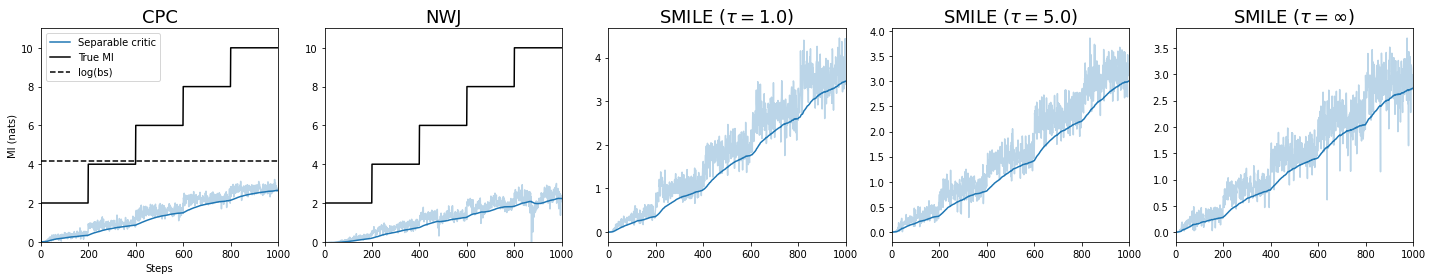

In [ ]:
# Plot 5 of the results, InfoNCE, NWJ, Smile 1.0, 5.0, infty

ncols = 5
nrows = 1
EMA_SPAN = 200
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axs = np.ravel(axs)

mi_true = mi_schedule(opt_params['iterations'])
        
for i, estimator in enumerate(['infonce', 'nwj']):
    key = f'{estimator}'
    plt.sca(axs[i])
    plt.title(find_name(key), fontsize=18)
    for net in ['separable']:
        mis = mi_numpys[net][key]
        p1 = plt.plot(mis, alpha=0.3)[0]
        mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
    plt.ylim(0, mi_true.max() * 1.1)
    plt.xlim(0, opt_params['iterations'])
    plt.plot(mi_true, color='k', label='True MI')
    if i == 0:
        plt.ylabel('MI (nats)')
        plt.xlabel('Steps')
        plt.axhline(np.log(64), color='k', ls='--', label='log(bs)')
        plt.legend()

estimator = 'smile'
for i, clip in enumerate([1.0, 5.0, None]):
    if clip is None:
        key = estimator
    else:
        key = f'{estimator}_{clip}'

    plt.sca(axs[i+2])
    plt.title(find_name(key), fontsize=18)
    for net in ['separable']:
        mis = mi_numpys[net][key]
        EMA_SPAN = 200
        p1 = plt.plot(mis, alpha=0.3)[0]
        mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
    # plt.plot(mi_true, color='k', label='True MI')
    # plt.ylim(0, mi_true.max() * 1.1)
    plt.xlim(0, opt_params['iterations'])

plt.gcf().tight_layout()

From the results above, the SMILE estimators have much better performance compared to the alternative methods with clipping.
We note that SMILE (infty) is simply a version of DV + JS, where we obtain density ratios from JS and use DV to directly estimate the mutual information. This has much higher variance, and is biased lower.